# MLP on MNIST with fixed sign update

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from EPLHb import EPLHb, gd, adam

import numpy as np
from scipy import stats

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# rcParams['figure.figsize'] = [20, 4]
# rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

## Generate data

In [2]:
#@title Downloading data

train_dataset = datasets.MNIST(root = './data', train = True,
                        transform = transforms.ToTensor(), download = True)

test_dataset = datasets.MNIST(root = './data', train = False,
                       transform = transforms.ToTensor())

In [3]:
#@title Loading the data
batch_size = 100 # the size of input data took for one iteration
train_loader = DataLoader(dataset = train_dataset,batch_size = batch_size,shuffle = True)
test_loader = DataLoader(dataset = test_dataset,batch_size = batch_size,shuffle = False)

In [4]:
#@title Define Hyperparameters
image, label = train_dataset.__getitem__(0)
input_size = image.numel()
hidden_size = 500 # number of nodes at hidden layer
output_size = 10 # number of output classes discrete range [0,9]
num_epochs = 20 # number of times which the entire dataset is passed throughout the model
lr = 1e-3 # size of step

## Normal MLP

In [9]:
corelease_net = EPLHb(input_size,hidden_size,output_size,fixed_sign=False,real_circuit=True)
if torch.cuda.is_available(): corelease_net.cuda()

# Initalize training details
loss_function = nn.CrossEntropyLoss()
# optimizer = gd(net.parameters(), lr=lr)
optimizer = adam(corelease_net.parameters(), lr=lr,fixed_sign=False)
cr_training_loss = []
cr_test_accuracy = []

In [10]:
corelease_net

EPLHb(
  (EP_to_LHb): Linear(in_features=784, out_features=500, bias=True)
  (LHb_to_DAN): Linear(in_features=500, out_features=10, bias=True)
  (relu): ReLU()
  (tanh): Tanh()
)

EP_to_LHb.weight
 Positive: 50.00816583633423%; Negative: 49.99183714389801%; Zero: 0.0%
EP_to_LHb.bias
 Positive: 46.799999475479126%; Negative: 53.200000524520874%; Zero: 0.0%
LHb_to_DAN.weight
 Positive: 0.0%; Negative: 100.0%; Zero: 0.0%
LHb_to_DAN.bias
 Positive: 30.000001192092896%; Negative: 69.9999988079071%; Zero: 0.0%


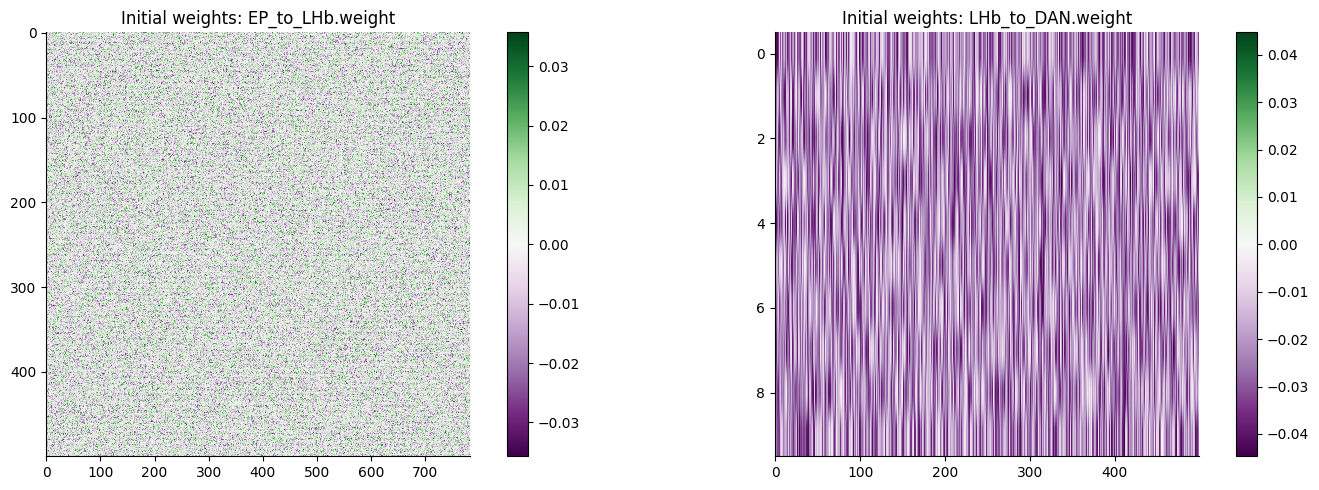

In [11]:
# Save the initial weights
initial_params_corelease = corelease_net.record_params()

# Plot initialized weights
fig, axs = plt.subplots(1,int(len(initial_params_corelease)/2),figsize=(15, 5))
plt.subplots_adjust(hspace=0.5)

ax = 0
for key, value in initial_params_corelease.items():
    if "bias" in key: continue
    im = axs[ax].imshow(value.numpy(), cmap='PRGn', aspect=value.shape[1]/value.shape[0],
                        vmax=abs(value.numpy()).max(), vmin=-abs(value.numpy()).max())
    axs[ax].set_title('Initial weights: ' + key)
    plt.colorbar(im)
    ax += 1

plt.tight_layout()
plt.show()

Epoch [1/20], Iteration: 0, Loss: 2.3089, Accuracy: 20.2700
Epoch [1/20], Iteration: 100, Loss: 1.0850, Accuracy: 89.4600
Epoch [1/20], Iteration: 200, Loss: 1.0348, Accuracy: 90.6000
Epoch [1/20], Iteration: 300, Loss: 0.9468, Accuracy: 91.5500
Epoch [1/20], Iteration: 400, Loss: 0.9215, Accuracy: 92.2300
Epoch [1/20], Iteration: 500, Loss: 0.9602, Accuracy: 92.4600
Epoch [2/20], Iteration: 0, Loss: 0.9070, Accuracy: 93.2600
Epoch [2/20], Iteration: 100, Loss: 0.9287, Accuracy: 93.3500
Epoch [2/20], Iteration: 200, Loss: 0.9221, Accuracy: 93.5600
Epoch [2/20], Iteration: 300, Loss: 0.8380, Accuracy: 94.1300
Epoch [2/20], Iteration: 400, Loss: 0.8575, Accuracy: 94.3400
Epoch [2/20], Iteration: 500, Loss: 0.8803, Accuracy: 94.4700
Epoch [3/20], Iteration: 0, Loss: 0.9043, Accuracy: 94.6400
Epoch [3/20], Iteration: 100, Loss: 0.8903, Accuracy: 94.8700
Epoch [3/20], Iteration: 200, Loss: 0.8829, Accuracy: 95.2400
Epoch [3/20], Iteration: 300, Loss: 0.8961, Accuracy: 95.3000
Epoch [3/20], 

Text(0.5, 1.0, 'Test Accuracy')

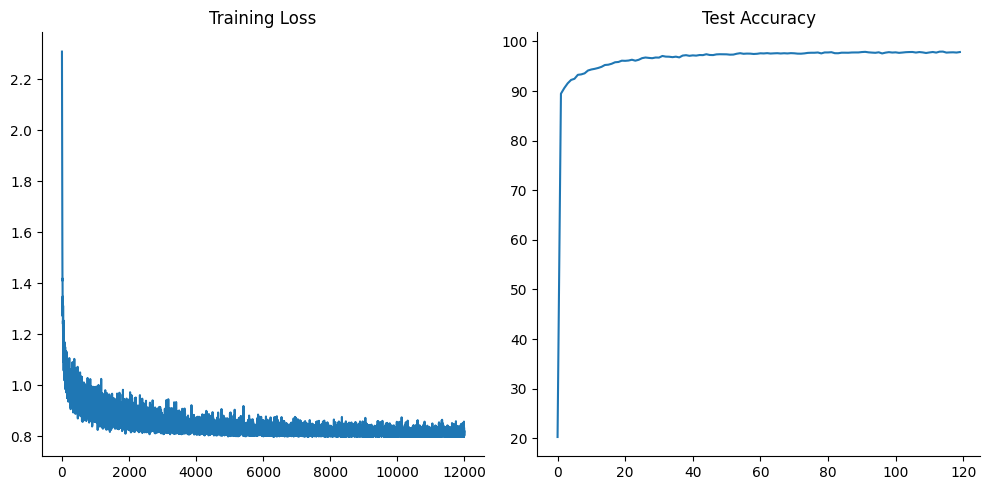

In [12]:
# Train the network
training_loss,test_accuracy = corelease_net.train_model(num_epochs,train_loader,optimizer,loss='CrossEntropyLoss',
                                            test_loader=test_loader,print_epoch=True)
cr_training_loss.extend(training_loss)
cr_test_accuracy.extend(test_accuracy)

# Plot training loss
fig, ax = plt.subplots(1,2,figsize=(10, 5))
ax[0].plot(cr_training_loss)
ax[0].set_title('Training Loss')
ax[1].plot(cr_test_accuracy)
ax[1].set_title('Test Accuracy')

EP_to_LHb.weight
 Positive: 55.06377816200256%; Negative: 44.936224818229675%; Zero: 0.0%
EP_to_LHb.bias
 Positive: 66.00000262260437%; Negative: 34.00000035762787%; Zero: 0.0%
LHb_to_DAN.weight
 Positive: 0.0%; Negative: 96.93999886512756%; Zero: 3.060000017285347%
LHb_to_DAN.bias
 Positive: 30.000001192092896%; Negative: 69.9999988079071%; Zero: 0.0%


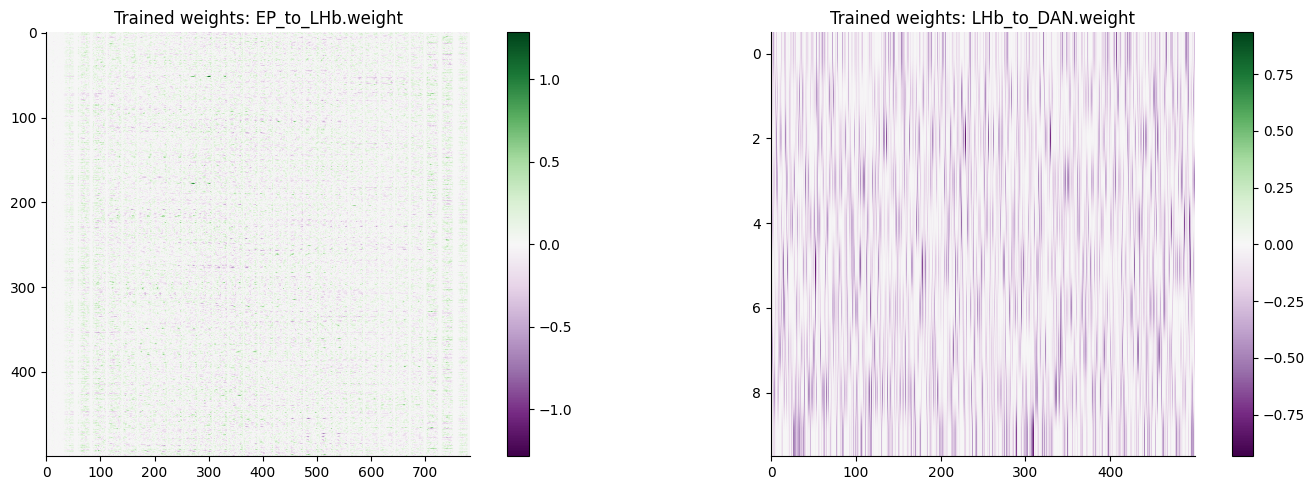

In [14]:
# Save the trianed parameters in paramList
trained_params_corelease = corelease_net.record_params()

# Plot initialized weights
fig, axs = plt.subplots(1,int(len(trained_params_corelease)/2),figsize=(15, 5))
plt.subplots_adjust(hspace=0.5)

ax = 0
for key, value in trained_params_corelease.items():
    if "bias" in key: continue
    im = axs[ax].imshow(value.numpy(), cmap='PRGn', aspect=value.shape[1]/value.shape[0],
                        vmax=abs(value.numpy()).max(), vmin=-abs(value.numpy()).max())
    axs[ax].set_title('Trained weights: ' + key)
    plt.colorbar(im)
    ax += 1

plt.tight_layout()
plt.show()

EP_to_LHb.weight flipped:  39.084% (153208/392000)
EP_to_LHb.bias flipped:  42.800% (214/500)
LHb_to_DAN.weight flipped:  0.000% (0/5000)
LHb_to_DAN.bias flipped:  20.000% (2/10)
EP_to_LHb.weight changed:  91.454% (358500/392000)
EP_to_LHb.bias changed:  100.000% (500/500)
LHb_to_DAN.weight changed:  100.000% (5000/5000)
LHb_to_DAN.bias changed:  100.000% (10/10)


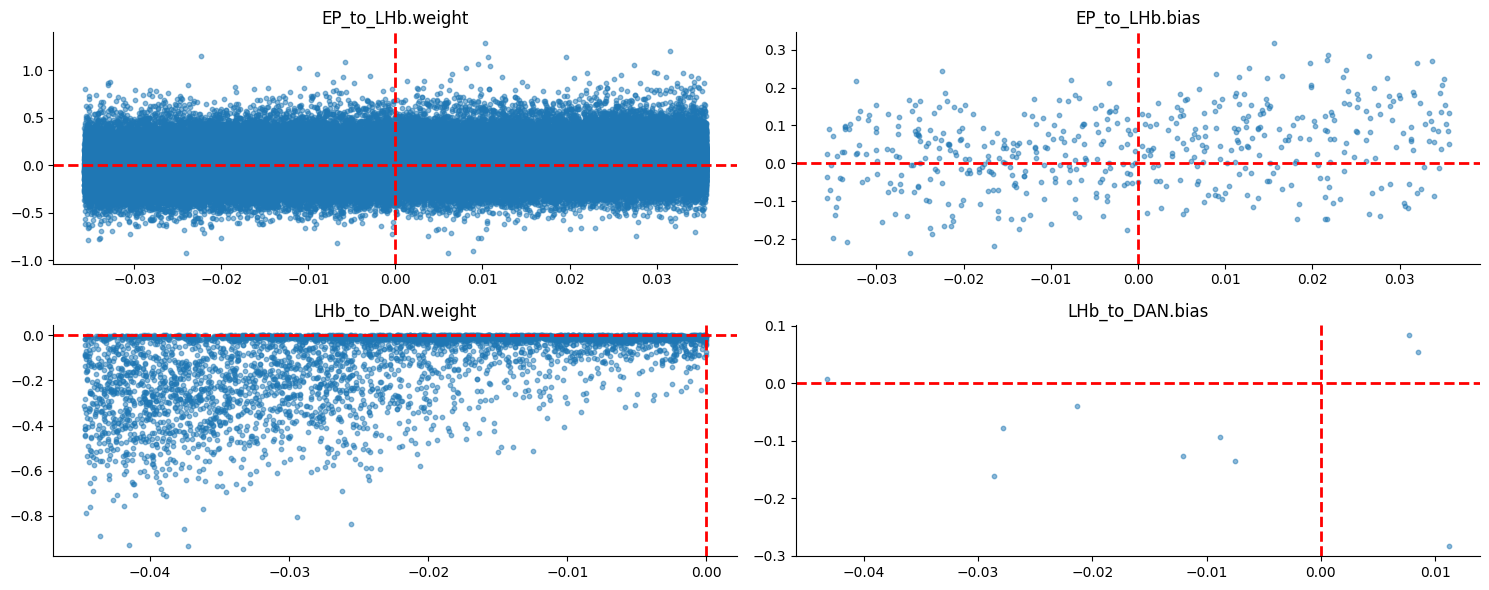

In [15]:
#@title What fraction of parameters flip sign?
for key in initial_params_corelease:
    n_weights=initial_params_corelease[key].numel()
    n_flip = (initial_params_corelease[key].sign()*trained_params_corelease[key].sign()<0).count_nonzero().item()
    print(key + ' flipped: % .3f%% (%d/%d)' %(100*n_flip/n_weights, n_flip, n_weights))

for key in initial_params_corelease:
    n_weights=initial_params_corelease[key].numel()
    n_changed = (initial_params_corelease[key] != trained_params_corelease[key]).count_nonzero().item()
    print(key + ' changed: % .3f%% (%d/%d)' %(100*n_changed/n_weights, n_changed, n_weights))

# Plot initial vs trained values

fig, axs = plt.subplots(2,int(len(trained_params_corelease)/2),figsize=(15, 6))
plt.subplots_adjust(hspace=0.5)

ax = 0
for i, ax in enumerate(axs.flatten()):
    key = list(initial_params_corelease)[i]
    ax.scatter(initial_params_corelease[key].numpy(),trained_params_corelease[key].numpy(),s=10,alpha=0.5)
    ax.axhline(y=0, linewidth=2, color = 'r', ls='--')
    ax.axvline(x=0, linewidth=2, color = 'r', ls='--')
    ax.set_title(key)

plt.tight_layout()
plt.show()

## Fixed-sign MLP

In [16]:
fixed_sign_net = EPLHb(input_size,hidden_size,output_size,fixed_sign=True,real_circuit=True)
if torch.cuda.is_available(): fixed_sign_net.cuda()

# fs_optimizer = gd(fixed_sign_net.parameters(), lr=lr, fixed_sign=True)
fs_optimizer = adam(fixed_sign_net.parameters(), lr=lr, fixed_sign=True)
fs_training_loss = []
fs_test_accuracy = []

EP_to_LHb.weight
 Positive: 50.38265585899353%; Negative: 49.61734712123871%; Zero: 0.0%
EP_to_LHb.bias
 Positive: 50.199997425079346%; Negative: 49.799999594688416%; Zero: 0.0%
LHb_to_DAN.weight
 Positive: 0.0%; Negative: 100.0%; Zero: 0.0%
LHb_to_DAN.bias
 Positive: 60.00000238418579%; Negative: 40.00000059604645%; Zero: 0.0%


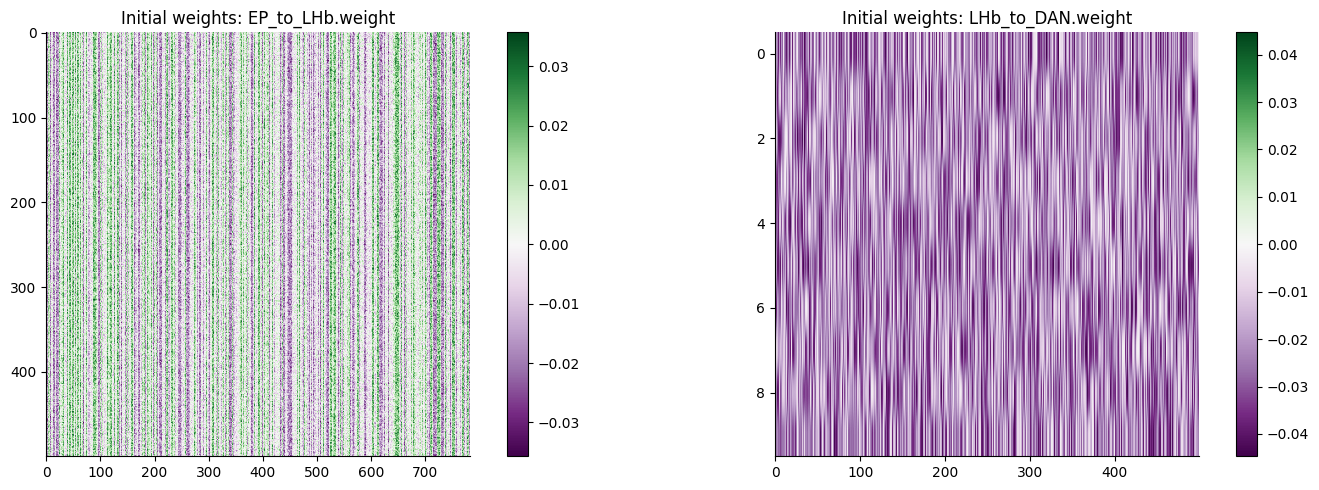

In [17]:
# Save the initial weights
initial_params_fixed = fixed_sign_net.record_params()

# Plot initialized weights
fig, axs = plt.subplots(1,int(len(initial_params_fixed)/2),figsize=(15, 5))
plt.subplots_adjust(hspace=0.5)

ax = 0
for key, value in initial_params_fixed.items():
    if "bias" in key: continue
    im = axs[ax].imshow(value.numpy(), cmap='PRGn', aspect=value.shape[1]/value.shape[0],
                        vmax=abs(value.numpy()).max(), vmin=-abs(value.numpy()).max())
    axs[ax].set_title('Initial weights: ' + key)
    plt.colorbar(im)
    ax += 1

plt.tight_layout()
plt.show()

In [18]:
# Training fixed sign model
training_loss, test_accuracy = fixed_sign_net.train_model(num_epochs,train_loader,fs_optimizer,loss='CrossEntropyLoss',
                                                          test_loader=test_loader,print_epoch=True)
fs_training_loss.extend(training_loss)
fs_test_accuracy.extend(test_accuracy)

Epoch [1/20], Iteration: 0, Loss: 2.3025
Epoch [1/20], Iteration: 100, Loss: 1.1210
Epoch [1/20], Iteration: 200, Loss: 1.0798
Epoch [1/20], Iteration: 300, Loss: 1.0270
Epoch [1/20], Iteration: 400, Loss: 1.0023
Epoch [1/20], Iteration: 500, Loss: 0.9255
Epoch [2/20], Iteration: 0, Loss: 1.0021
Epoch [2/20], Iteration: 100, Loss: 0.9762
Epoch [2/20], Iteration: 200, Loss: 0.9177
Epoch [2/20], Iteration: 300, Loss: 0.9918
Epoch [2/20], Iteration: 400, Loss: 0.9104
Epoch [2/20], Iteration: 500, Loss: 0.9958
Epoch [3/20], Iteration: 0, Loss: 0.9149
Epoch [3/20], Iteration: 100, Loss: 0.9500
Epoch [3/20], Iteration: 200, Loss: 0.8961
Epoch [3/20], Iteration: 300, Loss: 0.9732
Epoch [3/20], Iteration: 400, Loss: 1.0053
Epoch [3/20], Iteration: 500, Loss: 0.9693
Epoch [4/20], Iteration: 0, Loss: 0.9562
Epoch [4/20], Iteration: 100, Loss: 0.8570
Epoch [4/20], Iteration: 200, Loss: 0.9308
Epoch [4/20], Iteration: 300, Loss: 0.8942
Epoch [4/20], Iteration: 400, Loss: 0.9132
Epoch [4/20], Itera

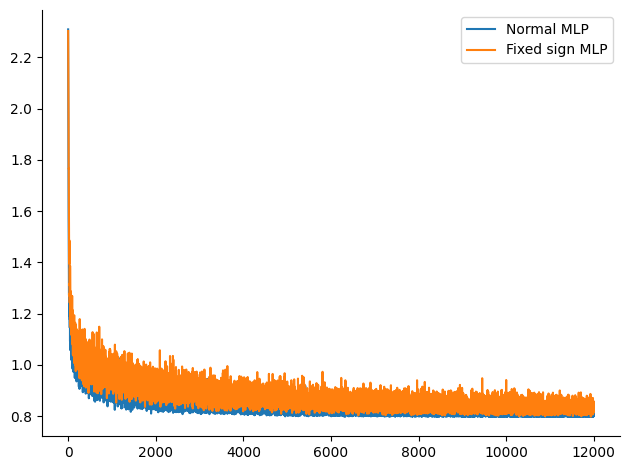

In [19]:
fig, ax = plt.subplots(1,2,figsize=(10, 5))

# Plot training loss history
plt.plot(cr_training_loss, label='EP-LHb')
plt.plot(fs_training_loss, label='Fixed sign EP-LHb')
plt.legend()

ax[0].plot(cr_training_loss, label='EP-LHb')
ax[0].plot(fs_training_loss, label='Fixed sign EP-LHb')
ax[0].set_title('Training Loss')
ax[0].legend()

ax[1].plot(cr_test_accuracy, label='EP-LHb')
ax[1].plot(fs_test_accuracy, label='Fixed sign EP-LHb')
ax[1].set_title('Test Accuracy')
ax[1].legend()

EP_to_LHb.weight
 Positive: 47.403061389923096%; Negative: 40.037500858306885%; Zero: 12.559439241886139%
EP_to_LHb.bias
 Positive: 50.0%; Negative: 46.59999907016754%; Zero: 3.400000184774399%
LHb_to_DAN.weight
 Positive: 0.0%; Negative: 89.35999870300293%; Zero: 10.639999806880951%
LHb_to_DAN.bias
 Positive: 50.0%; Negative: 40.00000059604645%; Zero: 10.000000149011612%


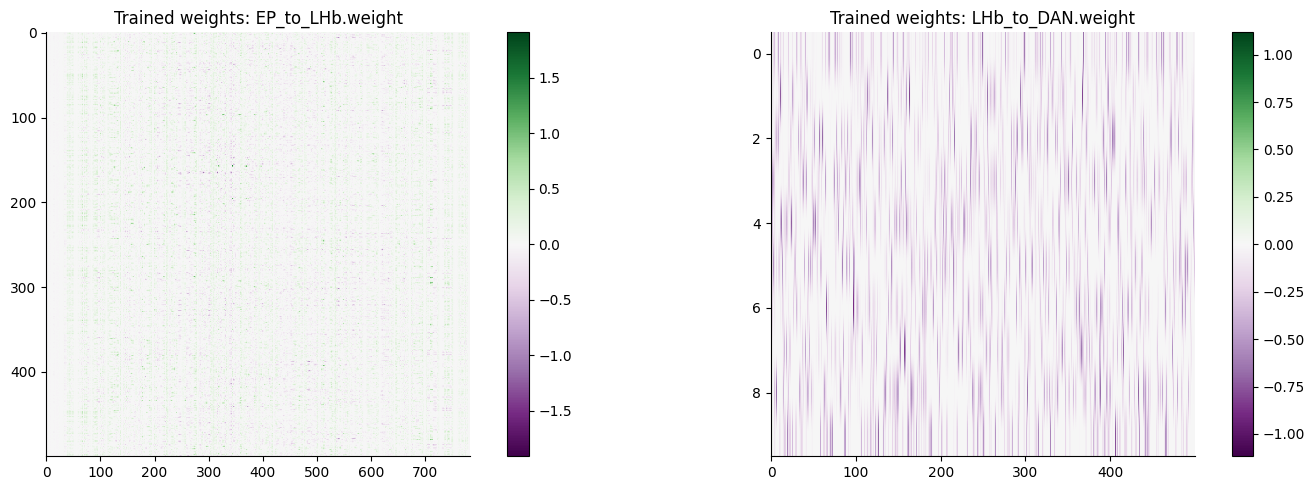

In [20]:
# Save the trianed parameters in paramList
trained_params_fixed = fixed_sign_net.record_params()

# Plot initialized weights
fig, axs = plt.subplots(1,int(len(initial_params_fixed)/2),figsize=(15, 5))
plt.subplots_adjust(hspace=0.5)

ax = 0
for key, value in trained_params_fixed.items():
    if "bias" in key: continue
    im = axs[ax].imshow(value.numpy(), cmap='PRGn', aspect=value.shape[1]/value.shape[0],
                        vmax=abs(value.numpy()).max(), vmin=-abs(value.numpy()).max())
    axs[ax].set_title('Trained weights: ' + key)
    plt.colorbar(im)
    ax += 1

plt.tight_layout()
plt.show()

EP_to_LHb.weight flipped:  0.000% (0/392000)
EP_to_LHb.bias flipped:  0.000% (0/500)
LHb_to_DAN.weight flipped:  0.000% (0/5000)
LHb_to_DAN.bias flipped:  0.000% (0/10)
EP_to_LHb.weight changed:  91.454% (358500/392000)
EP_to_LHb.bias changed:  100.000% (500/500)
LHb_to_DAN.weight changed:  100.000% (5000/5000)
LHb_to_DAN.bias changed:  100.000% (10/10)


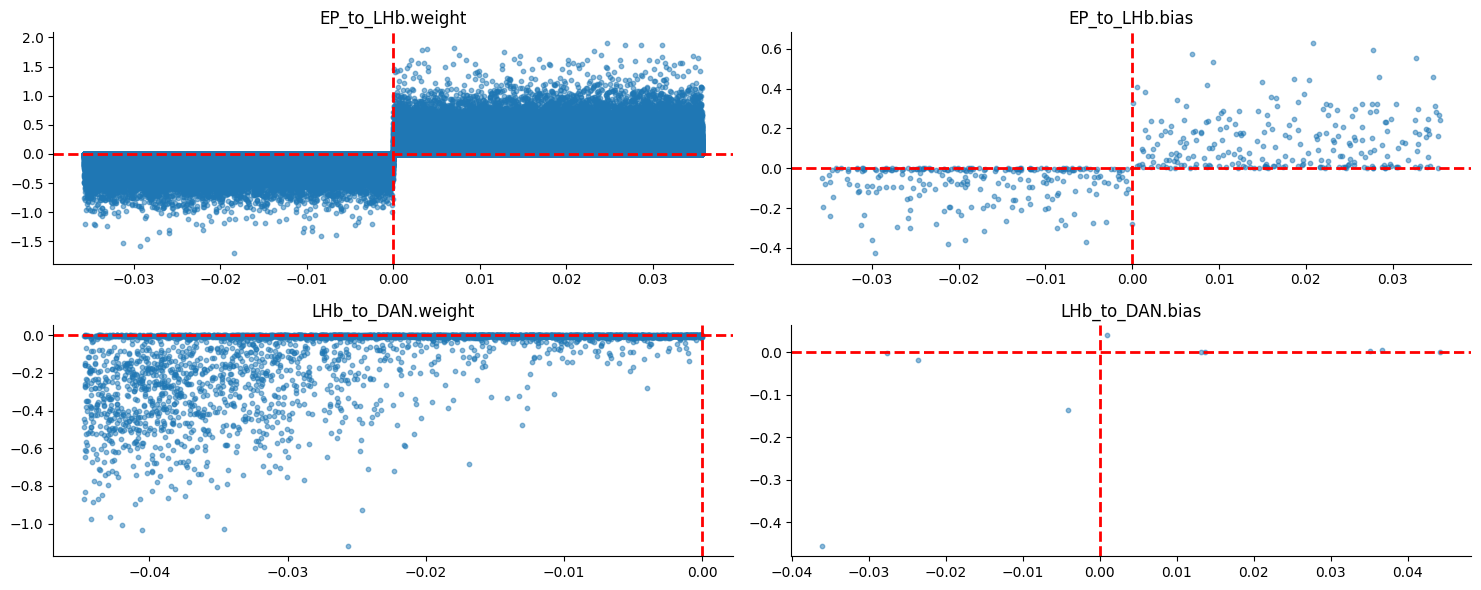

In [21]:
#@title What fraction of parameters flip sign?
for key in initial_params_fixed:
    n_weights=initial_params_fixed[key].numel()
    n_flip = (initial_params_fixed[key].sign()*trained_params_fixed[key].sign()<0).count_nonzero().item()
    print(key + ' flipped: % .3f%% (%d/%d)' %(100*n_flip/n_weights, n_flip, n_weights))

for key in initial_params_fixed:
    n_weights=initial_params_fixed[key].numel()
    n_changed = (initial_params_fixed[key] != trained_params_fixed[key]).count_nonzero().item()
    print(key + ' changed: % .3f%% (%d/%d)' %(100*n_changed/n_weights, n_changed, n_weights))

# Plot initial vs trained values

fig, axs = plt.subplots(2,int(len(trained_params_fixed)/2),figsize=(15, 6))
plt.subplots_adjust(hspace=0.5)

ax = 0
for i, ax in enumerate(axs.flatten()):
    key = list(initial_params_fixed)[i]
    ax.scatter(initial_params_fixed[key].numpy(),trained_params_fixed[key].numpy(),s=10,alpha=0.5)
    ax.axhline(y=0, linewidth=2, color = 'r', ls='--')
    ax.axvline(x=0, linewidth=2, color = 'r', ls='--')
    ax.set_title(key)

plt.tight_layout()
plt.show()

## Weight change analysis

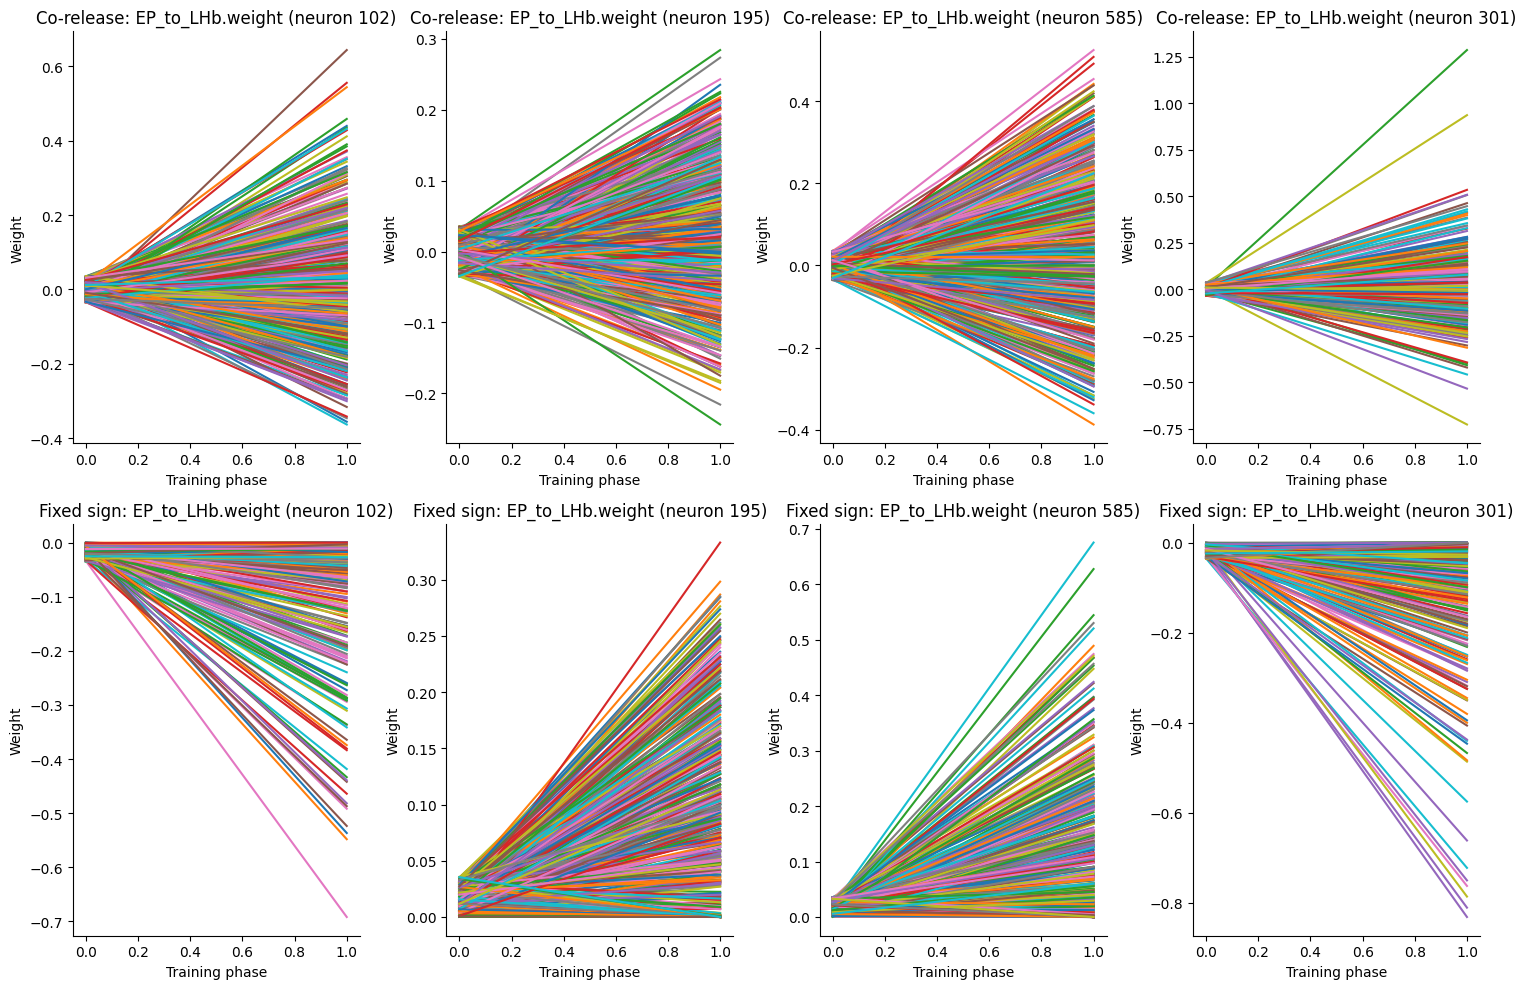

In [22]:
# Plot flipped EP neuron weight changes
n_row = 2
n_col = 4

fig, axs = plt.subplots(n_row,n_col,figsize=(15, 10))
plt.subplots_adjust(hspace=0.5)

key = list(initial_params_corelease)[0]
picked_neurons = torch.randint(1,input_size,(n_col,))

for i, neuron in enumerate(picked_neurons):
    weight_history_corelease = [initial_params_corelease[key][:,neuron].flatten(),
                                trained_params_corelease[key][:,neuron].flatten()]

    weight_history_fixed = [initial_params_fixed[key][:,neuron].flatten(),
                            trained_params_fixed[key][:,neuron].flatten()]

    axs.flatten()[i].plot(weight_history_corelease)
    axs.flatten()[i].set_xlabel('Training phase')
    axs.flatten()[i].set_ylabel('Weight')
    axs.flatten()[i].set_title('Co-release: %s (neuron %d)' %(key, neuron))
    axs.flatten()[i+n_col].plot(weight_history_fixed)
    axs.flatten()[i+n_col].set_xlabel('Training phase')
    axs.flatten()[i+n_col].set_ylabel('Weight')
    axs.flatten()[i+n_col].set_title('Fixed sign: %s (neuron %d)' %(key, neuron))

plt.tight_layout()
plt.show()

## Train multiple networks per condition

Different initialization scenarios
- random initialization of every synapses
- Dale's law initialization of every synapses

Different network structure
- LHb to DAN is all inhibitory + LHb to LHb is all excitatory (if RNN)
- Every layer have mixed excitatory/inhibitory output

Different update methods
- Normal ADAM
- Fixed sign ADAM

In [ ]:
EP_size = 784 # img_size = (28,28) ---> 28*28=784 in total
LHb_size = 100 # number of nodes at hidden layer
DAN_size = 10 # number of output classes discrete range [0,9]
num_epochs = 10 # 20 # number of times which the entire dataset is passed throughout the model
lr = 1e-3 # size of step

prob_EP_to_LHb = 1
prob_LHb_to_LHb = 1
prob_LHb_to_DAN = 1

n_networks = 20 # number of networks to train

### Train multiple EP-LHb
1. Random initialization of EP-LHb inputs
2. LHb to DAN output is always negative
3. Train with normal ADAM

In [ ]:
cr_training_loss_summary = []
cr_test_accuracy_summary = []

for i in range(1,n_networks+1):
    # Initialize a network
    net = EPLHb(EP_size,LHb_size,DAN_size,
                rnn=True,fixed_sign=False,real_circuit=True,
                prob_EP_to_LHb=prob_EP_to_LHb,prob_LHb_to_LHb=prob_LHb_to_LHb,prob_LHb_to_DAN=prob_LHb_to_DAN)
    initial_params = net.record_params(calc_sign=False)
    net_training_loss = []
    net_test_accuracy = []
    if torch.cuda.is_available(): net.cuda()

    # Train on original data
    optimizer = adam(net.parameters(), lr=lr, fixed_sign=False)
    # scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    training_loss, test_accuracy = net.train_model(num_epochs,train_loader,optimizer,
                                    test_loader=test_loader,print_epoch=False,loss='CrossEntropyLoss')
    net_training_loss.extend(training_loss)
    net_test_accuracy.extend(test_accuracy)

    # Train on flipped data
    # optimizer = adam(net.parameters(), lr=lr, fixed_sign=False)
    # training_loss = net.train_model(num_epochs,flip_loader,optimizer,print_epoch=False)
    # net_training_loss.extend(training_loss)

    cr_training_loss_summary.append(net_training_loss)
    cr_test_accuracy_summary.append(net_test_accuracy)
    print('Finished training co-release network %d/%d' %(i,n_networks))

# Convert list to numpy array
cr_training_loss_summary = np.array(cr_training_loss_summary)
cr_test_accuracy_summary = np.array(cr_test_accuracy_summary)

# # Plot training loss for all network separately
# fig, axs = plt.subplots(n_networks,1,figsize=(15,3*n_networks))
# for i, ax in enumerate(axs.flatten()):
#     ax.plot(cr_training_loss_summary[i])
#     ax.set_title('Corelease # %d' %(i+1))

### Train multiple fixed sign EP-LHb
1. Synapses of a EP-LHb neuron have the same sign
2. LHb to DAN output is always negative
3. Use fixed sign version of ADAM

In [ ]:
fs_training_loss_summary = []
fs_test_accuracy_summary = []

for i in range(1,n_networks+1):
    # Initialize a network
    net = EPLHb(EP_size,LHb_size,DAN_size,
                rnn=True,fixed_sign=True,real_circuit=True,
                prob_EP_to_LHb=prob_EP_to_LHb,prob_LHb_to_LHb=prob_LHb_to_LHb,prob_LHb_to_DAN=prob_LHb_to_DAN)
    initial_params = net.record_params(calc_sign=False)
    net_training_loss = []
    net_test_accuracy = []
    if torch.cuda.is_available(): net.cuda()

    # Train on original data
    optimizer = adam(net.parameters(), lr=lr, fixed_sign=True)
    # scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    training_loss, test_accuracy = net.train_model(num_epochs,train_loader,optimizer,
                                    test_loader=test_loader,print_epoch=False,loss='CrossEntropyLoss')
    net_training_loss.extend(training_loss)
    net_test_accuracy.extend(test_accuracy)

    # Train on flipped data
    # optimizer = adam(net.parameters(), lr=lr, fixed_sign=True)
    # training_loss = net.train_model(num_epochs,flip_loader,optimizer,print_epoch=False)
    # net_training_loss.extend(training_loss)

    fs_training_loss_summary.append(net_training_loss)
    fs_test_accuracy_summary.append(net_test_accuracy)
    print('Finished training fixed sign network %d/%d' %(i,n_networks))

# Convert list to numpy array
fs_training_loss_summary = np.array(fs_training_loss_summary)
fs_test_accuracy_summary = np.array(fs_test_accuracy_summary)


# # Plot training loss for all network separately
# fig, axs = plt.subplots(n_networks,1,figsize=(15,3*n_networks))
# for i, ax in enumerate(axs.flatten()):
#     ax.plot(fs_training_loss_summary[i])
#     ax.set_title('Fixed # %d' %(i+1))

### Train fixed sign MLP
1. Synapses of neurons in every layer have the same sign
2. LHb to DAN can be positive or negative
3. Use fixed sign version of ADAM

In [ ]:
fs_posneg_training_loss_summary = []
fs_posneg_test_accuracy_summary = []

for i in range(1,n_networks+1):
    # Initialize a network
    net = EPLHb(EP_size,LHb_size,DAN_size,
                rnn=True, fixed_sign=True, real_circuit=False,
                prob_EP_to_LHb=prob_EP_to_LHb,prob_LHb_to_LHb=prob_LHb_to_LHb,prob_LHb_to_DAN=prob_LHb_to_DAN)
    initial_params = net.record_params(calc_sign=False)
    net_training_loss = []
    net_test_accuracy = []
    if torch.cuda.is_available(): net.cuda()

    # Train on original data
    optimizer = adam(net.parameters(), lr=lr, fixed_sign=True)
    # scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    training_loss, test_accuracy = net.train_model(num_epochs,train_loader,optimizer,
                                    test_loader=test_loader,print_epoch=False,loss='CrossEntropyLoss')
    net_training_loss.extend(training_loss)
    net_test_accuracy.extend(test_accuracy)

    # Train on flipped data
    # optimizer = adam(net.parameters(), lr=lr, fixed_sign=True)
    # training_loss = net.train_model(num_epochs,flip_loader,optimizer,print_epoch=False)
    # net_training_loss.extend(training_loss)

    fs_posneg_training_loss_summary.append(net_training_loss)
    fs_posneg_test_accuracy_summary.append(net_test_accuracy)
    print('Finished training fixed sign network %d/%d' %(i,n_networks))

# Convert list to numpy array
fs_posneg_training_loss_summary = np.array(fs_posneg_training_loss_summary)
fs_posneg_test_accuracy_summary = np.array(fs_posneg_test_accuracy_summary) 

# # Plot training loss for all network separately
# fig, axs = plt.subplots(n_networks,1,figsize=(15,3*n_networks))
# for i, ax in enumerate(axs.flatten()):
#     ax.plot(fs_training_loss_summary[i])
#     ax.set_title('Fixed # %d' %(i+1))

### Plot summary

In [ ]:
# Loss
mean_cr_loss = np.mean(cr_training_loss_summary,axis=0)
sem_cr_loss = stats.sem(cr_training_loss_summary)
mean_fs_loss = np.mean(fs_training_loss_summary,axis=0)
sem_fs_loss = stats.sem(fs_training_loss_summary)
mean_fs_posneg_loss = np.mean(fs_posneg_training_loss_summary,axis=0)
sem_fs_posneg_loss = stats.sem(fs_posneg_training_loss_summary)

# Test accuracy
mean_cr_accuracy = np.mean(cr_test_accuracy_summary,axis=0)
sem_cr_accuracy = stats.sem(cr_test_accuracy_summary)
mean_fs_accuracy = np.mean(fs_test_accuracy_summary,axis=0)
sem_fs_accuracy = stats.sem(fs_test_accuracy_summary)
mean_fs_posneg_accuracy = np.mean(fs_posneg_test_accuracy_summary,axis=0)
sem_fs_posneg_accuracy = stats.sem(fs_posneg_test_accuracy_summary)

# Plot
fig, axs = plt.subplots(1,2,figsize=(15, 5))

# Plot loss
x = np.linspace(1,mean_cr_loss.shape[0],num=mean_cr_loss.shape[0],dtype='int32')
axs[0].plot(mean_cr_loss, label='Co-release')
axs[0].fill_between(x,mean_cr_loss+sem_cr_loss,mean_cr_loss-sem_cr_loss,alpha=0.2)
axs[0].plot(mean_fs_loss, label='Fixed sign')
axs[0].fill_between(x,mean_fs_loss+sem_fs_loss,mean_fs_loss-sem_fs_loss,alpha=0.2)
axs[0].plot(mean_fs_posneg_loss, label='Fixed sign without neg output')
axs[0].fill_between(x,mean_fs_posneg_loss+sem_fs_posneg_loss,mean_fs_posneg_loss-sem_fs_posneg_loss,alpha=0.2)

axs[0].set_xlabel('Trianing epochs')
axs[0].set_ylabel('Training loss')
axs[0].legend()

# Plot accuracy
x = np.linspace(1,mean_cr_accuracy.shape[0],num=mean_cr_accuracy.shape[0],dtype='int32')
axs[0].plot(mean_cr_accuracy, label='Co-release')
axs[0].fill_between(x,mean_cr_accuracy+sem_cr_accuracy,mean_cr_accuracy-sem_cr_accuracy,alpha=0.2)
axs[0].plot(mean_fs_accuracy, label='Fixed sign')
axs[0].fill_between(x,mean_fs_accuracy+sem_fs_accuracy,mean_fs_accuracy-sem_fs_accuracy,alpha=0.2)
axs[0].plot(mean_fs_posneg_accuracy, label='Fixed sign without neg output')
axs[0].fill_between(x,mean_fs_posneg_accuracy+sem_fs_posneg_accuracy,mean_fs_posneg_accuracy-sem_fs_posneg_accuracy,alpha=0.2)

axs[0].set_xlabel('Trianing epochs')
axs[0].set_ylabel('Training loss')
axs[0].legend()